In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from multiprocessing import Pool
import tensorflow as tf
from tensorflow.python.ops import nn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout
from tensorflow.keras import Input, Model
from utils import *
py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))





tf.device('GPU:1') 

2022-03-14 11:12:05.738421: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-14 11:12:06.957308: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


2022-03-14 11:12:06.959371: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-14 11:12:07.007493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-14 11:12:07.007979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-14 11:12:07.008018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-14 11:12:07.018852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03

## Loading the data

In [2]:
Nbr_train = int(1E6)

Nbr_test = int(2E5) 

#outfile = 'Dataset/' # choose your path 

In [3]:
Nbr_test_bruteforce = 10000


project_sub_path = "Imperfect CSI Data/CF_DNN"
  
# Parent Directory path
parent_dir = ""
### Train ###
#dataset_train_Anne
dataset_train = np.load(os.path.join(parent_dir,project_sub_path,'dataset_train_GF.npz'))

h_11_tr = dataset_train['h_PP'][:Nbr_train]
h_12_tr = dataset_train['h_PS'][:Nbr_train]
h_1R_tr = dataset_train['h_PR'][:Nbr_train]
h_21_tr = dataset_train['h_SP'][:Nbr_train]
h_22_tr = dataset_train['h_SS'][:Nbr_train]
h_2R_tr = dataset_train['h_SR'][:Nbr_train]
h_R1_tr = dataset_train['h_RP'][:Nbr_train]
h_R2_tr = dataset_train['h_RS'][:Nbr_train]


#x_train_input = np.stack([h_11_tr, h_12_tr, h_1R_tr, h_21_tr, h_22_tr, h_2R_tr, h_R1_tr, h_R2_tr], axis=1)
x_train = np.stack([h_R1_tr, h_11_tr, h_2R_tr, h_1R_tr, h_22_tr, h_R2_tr, h_21_tr, h_12_tr], axis=1)





### VAL ###
  
# Parent Directory path
#dataset_val_Anne

dataset_test = np.load(os.path.join(parent_dir,project_sub_path,'dataset_val_GF.npz'))

h_11_test = dataset_test['h_PP'][:Nbr_test_bruteforce]
h_12_test = dataset_test['h_PS'][:Nbr_test_bruteforce]
h_1R_test = dataset_test['h_PR'][:Nbr_test_bruteforce]
h_21_test = dataset_test['h_SP'][:Nbr_test_bruteforce]
h_22_test = dataset_test['h_SS'][:Nbr_test_bruteforce]
h_2R_test = dataset_test['h_SR'][:Nbr_test_bruteforce]
h_R1_test = dataset_test['h_RP'][:Nbr_test_bruteforce]
h_R2_test = dataset_test['h_RS'][:Nbr_test_bruteforce]

x_test = np.stack([h_R1_test, h_11_test, h_2R_test, h_1R_test, h_22_test, h_R2_test, h_21_test, h_12_test], axis=1)



# CF loss function

In [4]:
def loss_CF(Lambda=10**0.5, v_tau=0.25):
    
    def CF_loss(G, y_out):
        
        ''' compute loss for CF Relaying'''
        
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        W = tf.constant(Lambda, dtype=tf.float32)  # ==> lambda 

        G = tf.cast(G, dtype='float32')
        
        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval

        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx  = [0], [1], [2], [3], [4], [5], [6], [7]
        
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        
        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)

        #  Primary power Creation

        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10.0)

        # NS_Tilde :NS = gPS*PP +1

        NS_Tilde = tf.add(tf.multiply(Gps,Pp),tf.constant(1, dtype=tf.float32))

        #NR_Tilde : gPR*PP +1

        NR_Tilde = tf.add(tf.multiply(Gpr,Pp),tf.constant(1, dtype=tf.float32))

        # Rho_Z : sqrt(Gpr*Gps)*Pp/sqrt(NR_tilde*NS_tilde)

        Rho_Z = tf.divide(tf.multiply(tf.sqrt(tf.multiply(Gpr,Gps)),Pp),tf.sqrt(tf.multiply(NR_Tilde,NS_Tilde)))

        #K1 : Gsr*NS_Tilde+Gss*NR_Tilde-2*Rho_Z*sqrt(Gsr*Gss*NR_Tilde*NS_Tilde)

        E1 = tf.add(tf.multiply(Gsr,NS_Tilde),tf.multiply(Gss,NR_Tilde))

        E2 = tf.sqrt(tf.multiply(tf.multiply(tf.multiply(Gsr,Gss),NR_Tilde),NS_Tilde))

        K1 = tf.math.subtract(E1,tf.multiply(tf.multiply(tf.constant(2, dtype=tf.float32),Rho_Z),E2))

        #K2 : (1-Rho_Z**2)*NR_Tilde*NS_Tilde
        
        K2 = tf.multiply(tf.math.subtract(tf.constant(1, dtype=tf.float32),tf.pow(Rho_Z,tf.constant(2, dtype=tf.float32))),tf.multiply(NR_Tilde,NS_Tilde))

        # function A' ==> A'(Gpp) : ((Gpp*Pp)/((1+(Gpp*Pp))**(1-tau)-1))-1 ==> (Gpp*Pp)/(R1) 

        R1 = tf.add(tf.constant(1, dtype=tf.float32),tf.multiply(Gpp,Pp))
        R1 = tf.pow(R1, tf.math.subtract(tf.constant(1, dtype=tf.float32),Tau))
        R1 = tf.math.subtract(R1,tf.constant(1, dtype=tf.float32))

        A_ = tf.subtract(tf.divide(tf.multiply(Gpp,Pp),R1),tf.constant(1, dtype=tf.float32))

        # QoS : 

        # PR**2 and PS**2 because custom_sigmoid(x):  
        # returns : Output of sigmoid function range between 0 and sqrt(10)

        Qos = tf.add(tf.multiply(Gsp,tf.pow(Ps,2)),tf.multiply(Grp,tf.pow(Pr,2)))

        Qos = tf.subtract(Qos, A_)

        Qos = tf.multiply(W,tf.keras.activations.relu(Qos)) 

        # SNR : 
        num = tf.add(tf.multiply(tf.multiply(tf.multiply(K1,Grs),\
                                             tf.pow(Ps,2)),tf.pow(Pr,2)),\
                     tf.add(tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),tf.multiply(K1,tf.pow(Ps,2))),\
                     tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),K2)))
        
        d_num = tf.add(tf.multiply(tf.multiply(K2,Grs), tf.pow(Pr,2)),\
                       tf.add(tf.multiply(NS_Tilde,tf.multiply(K1,tf.pow(Ps,2))),\
                       tf.multiply(NS_Tilde, K2)))
        
        SNR_opt = tf.divide(num, d_num)

        # R_S

        Rs_opt =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_opt)))

        #-n_SNR+n_Qos
        res = tf.reduce_mean(-Rs_opt+Qos) 


        return res
    return CF_loss



# DNN Model 

In [5]:
def get_model_CF(X_train, f_loss, f_metrics, f_activation1, f_activation2, LR) :
    """

      Structure of DL model for DF.

      Parameters:
         X_train: Channel gain array.
         f_loss: Loss function.
         f_metrics: List of metrics.
         f_activation1: First activation function for the output.
         f_activation2: Second activation function for the output.
         LR : Learning rate.
         
      Returns:
        DL model for CF.
    """
    opt = tf.keras.optimizers.Adam(learning_rate = LR)
    inputs = Input(shape=(X_train.shape[1]))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output1 = Dense(1, activation=f_activation1)(x)
    output2 = Dense(1, activation=f_activation2)(x)
    merged = tf.keras.layers.Concatenate()([output1, output2])
    model = Model(inputs=inputs, outputs=[merged])
    model.compile(loss=f_loss, optimizer=opt, metrics=f_metrics)
    model.summary()
    return model



# Performance metrics

In [6]:
#------------ tensorflow functions for DNN ------------# 
def custom_sigmoid(x):
    """
    Modified sigmoid function used for handling predicted powers.

    Parameters:
      x: tensor.
    Returns:
      Output of sigmoid function range between 0 and sqrt(10)
    """
    output = tf.multiply(tf.sqrt(tf.constant(10,dtype=tf.float32)),nn.sigmoid(x))
    # Cache the logits to use for crossentropy loss.
    output._keras_logits = x  # pylint: disable=protected-access
    return output




def log2(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(2, dtype=tf.float32))
    return numerator / denominator


def Delta_DNN(G, y_out):
 
    """
      Metrics used on DL model for Primary achievable rate degradation.
      
      Parameters:
        G: Channel gain tensor.
        y_out: Predicted parameter.
      Returns:
        Primary achievable rate degradation for each samples 
    """
    G = tf.cast(G, dtype='float32')
    y_out = tf.cast(y_out, dtype='float32')
    
    # index retrieval


    Grp_indx, Gpp_indx, Gsp_indx = [0], [1], [6]
    Pr_indx, Ps_indx  = [0], [1]

    # tensors retrieval
    Grp, Gpp, Gsp, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsp_indx, axis=1),  tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)
    
    
    #  Pp Creation
    Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)
    
    # Rp : C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Alpha*Ps*Pr)+1) ==> C(H1/H2), where H1 = Gpp*Pp and H2 = R1+R2+1
    H1 = tf.multiply(Gpp, Pp)

    R1 =  tf.add(tf.multiply(Grp, tf.pow(Pr, 2)),tf.multiply(Gsp,tf.pow(Ps, 2)))

    H2 = tf.add(R1, tf.constant(1,dtype=tf.float32))
    
    SNR_P = tf.divide(H1, H2)
    
    Rp =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P)))

    # Rp_ : C(Gpp*Pp)
    SNR_P_ = tf.multiply(Gpp, Pp)
    Rp_ = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P_)))
    # 1 - ratio(Rp, Rp_)
    RRP = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))
    
    return RRP



def Opportunistic_Achievable_Rate(v_tau):
    def opportunistic_rate(G, y_out):
        """
        Metrics used on DL model for throughput calculation.
        This function will get those parameters as input
        G: Channel gain tensor.
        y_out: Predicted parameter.

        Parameters:
        Lambda : Penalty for QoS
        Tau : degradation factor for the primary network
        Returns:
        Throughput mean 
        """

        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        G = tf.cast(G, dtype='float32')
        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval
    


        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx = [0], [1], [2], [3], [4], [5], [6], [7]
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)
        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)


        NS_Tilde = tf.add(tf.multiply(Gps,Pp),tf.constant(1, dtype=tf.float32))

        #NR_Tilde : gPR*PP +1

        NR_Tilde = tf.add(tf.multiply(Gpr,Pp),tf.constant(1, dtype=tf.float32))

        # Rho_Z : sqrt(Gpr*Gps)*Pp/sqrt(NR_tilde*NS_tilde)

        Rho_Z = tf.divide(tf.multiply(tf.sqrt(tf.multiply(Gpr,Gps)),Pp),tf.sqrt(tf.multiply(NR_Tilde,NS_Tilde)))


        #K1 : Gsr*NS_Tilde+Gss*NR_Tilde-2*Rho_Z*sqrt(Gsr*Gss*NR_Tilde*NS_Tilde)

        E1 = tf.add(tf.multiply(Gsr,NS_Tilde),tf.multiply(Gss,NR_Tilde))

        E2 = tf.sqrt(tf.multiply(tf.multiply(tf.multiply(Gsr,Gss),NR_Tilde),NS_Tilde))

        K1 = tf.math.subtract(E1,tf.multiply(tf.multiply(tf.constant(2, dtype=tf.float32),Rho_Z),E2))

        #K2 : (1-Rho_Z**2)*NR_Tilde*NS_Tilde

        K2 = tf.multiply(tf.math.subtract(tf.constant(1, dtype=tf.float32),tf.pow(Rho_Z,tf.constant(2, dtype=tf.float32))),tf.multiply(NR_Tilde,NS_Tilde))

        num = tf.add(tf.multiply(tf.multiply(tf.multiply(K1,Grs),tf.pow(Ps,2)),tf.pow(Pr,2)),tf.add(tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),tf.multiply(K1,tf.pow(Ps,2))),tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),K2)))
                
        d_num = tf.add(tf.multiply(tf.multiply(K2,Grs), tf.pow(Pr,2)),tf.add(tf.multiply(NS_Tilde,tf.multiply(K1,tf.pow(Ps,2))),tf.multiply(NS_Tilde,K2)))
        
        SNR_opt = tf.divide(num, d_num)

        #C = 1/2*log2(1+SNR_opt)
        # debit calculation
        Rs = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_opt)))
        return Rs
    return opportunistic_rate


def outage_percentage(v_tau): 
    def outage_percentage(G, y_out): 
        """
          metrics used on DL model for testing Primary achievable rate degradation percentage .

          Parameters:
            G: Channel gain tensor.
            y_out: Predicted parameter.
          Returns:
            percentage of Primary achievable rate degradation 
        """
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        G = tf.cast(G, dtype='float32')

        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval


        Grp_indx, Gpp_indx, Gsp_indx = [0], [1], [6]
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        Grp, Gpp, Gsp, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsp_indx, axis=1),  tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)


        #  Pp Creation
        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)

        # Rp : C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Alpha*Ps*Pr)+1) ==> C(H1/H2), where H1 = Gpp*Pp and H2 = R1+R2+1
        H1 = tf.multiply(Gpp, Pp)

        R1 =  tf.add(tf.multiply(Grp, tf.pow(Pr, 2)),tf.multiply(Gsp,tf.pow(Ps, 2)))

        H2 = tf.add(R1, tf.constant(1,dtype=tf.float32))

        SNR_P = tf.divide(H1, H2)

        Rp =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P)))

        # Rp_ : C(Gpp*Pp)
        SNR_P_ = tf.multiply(Gpp, Pp)
        Rp_ = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P_)))
        # 1 - ratio(Rp, Rp_)
        RRP = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))

        # 1 - ratio(Rp, Rp_)
        ARD = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))

        #ARD > tau  
        mask_PDD = tf.greater(ARD, Tau)# boolean array 

        return mask_PDD #*100 ?? 

    return outage_percentage


def QoS_Violation(v_tau, QoS_thresh = -5): 
    def V_Qos(G, y_out): 
        """
        metrics used on DL model for testing QoS viloation .

        Parameters:
            G: Channel gain tensor.
            y_out: Predicted parameter.
        Returns:
            Number of violated QoS 
        """
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        W = tf.constant(Lambda, dtype=tf.float32)  # ==> lambda 

        G = tf.cast(G, dtype='float32')

        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval

        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx  = [0], [1], [2], [3], [4], [5], [6], [7]

        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval

        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)

        #  Primary power Creation

        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10.0)

        # function A' ==> A'(Gpp) : ((Gpp*Pp)/((1+(Gpp*Pp))**(1-tau)-1))-1 ==> (Gpp*Pp)/(R1) 

        R1 = tf.add(tf.constant(1, dtype=tf.float32),tf.multiply(Gpp,Pp))
        R1 = tf.pow(R1, tf.math.subtract(tf.constant(1, dtype=tf.float32),Tau))
        R1 = tf.math.subtract(R1,tf.constant(1, dtype=tf.float32))

        A_ = tf.subtract(tf.divide(tf.multiply(Gpp,Pp),R1),tf.constant(1, dtype=tf.float32))

        # QoS : 

        # PR**2 and PS**2 because custom_sigmoid(x):  
        # returns : Output of sigmoid function range between 0 and sqrt(10)

        Qos = tf.add(tf.multiply(Gsp,tf.pow(Ps,2)),tf.multiply(Grp,tf.pow(Pr,2)))

        Qos = tf.subtract(Qos, A_)

        Qos = tf.multiply(W,tf.keras.activations.relu(Qos)) 

        Qos = tf.subtract(Qos, A_)

        #n_Qos = tf.divide(Qos, A_) # Normalization ?????
        #Qos > 10**-5  
        mask_pr = tf.greater(n_Qos,tf.math.pow(tf.constant(10, dtype=tf.float32),QoS_thresh))# boolean array 

        return mask_pr
    return V_Qos


In [71]:
Nbr_train = int(1E6)

 
tau = 0.25

VS = 0.2 # validation_split

Epochs = 500 # Epochs number

BS = 4096 # batch_size

LD = 10**0.5

LR = 10**-4

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

metrics = [Delta_DNN, Opportunistic_Achievable_Rate(tau),outage_percentage(tau)] #, QoS_mean_DF, QoS_median_DF



#Nbr_train = int(1E6)

model = get_model_CF(x_train, loss_CF(LD,tau), metrics, custom_sigmoid, custom_sigmoid, LR) #lr_v
history = model.fit(x_train, np.power(x_train,2), epochs=Epochs, batch_size=BS, validation_split = VS,callbacks=[callback])

model.save('WM_CF/CF.h5')
np.save('WM_CF/CF',history.history)




Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 128)          1152        input_9[0][0]                    
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 256)          33024       dense_48[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 256)          65792       dense_49[0][0]                   
____________________________________________________________________________________________

# Part 2 

Text(0, 0.5, 'Loss')

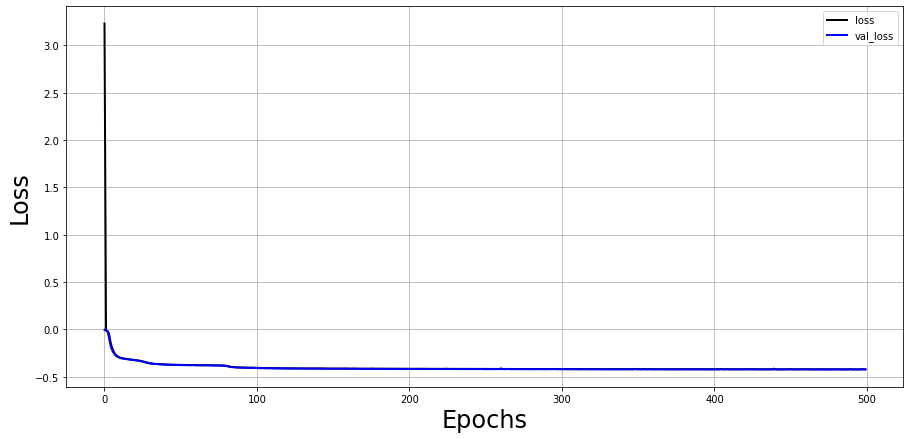

In [22]:
history = np.load('WM_CF/CF.npy',allow_pickle='TRUE').item()

fig, ax = plt.subplots(1,figsize=(15,7), sharey=True)
ax.grid()
ax.plot(history['loss'][:],color='black',lw=2,label='loss')
ax.plot(history['val_loss'][:],color='blue',lw=2,label='val_loss')
plt.legend(loc='best')
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Loss",fontsize=24)

Text(0, 0.5, 'Delta')

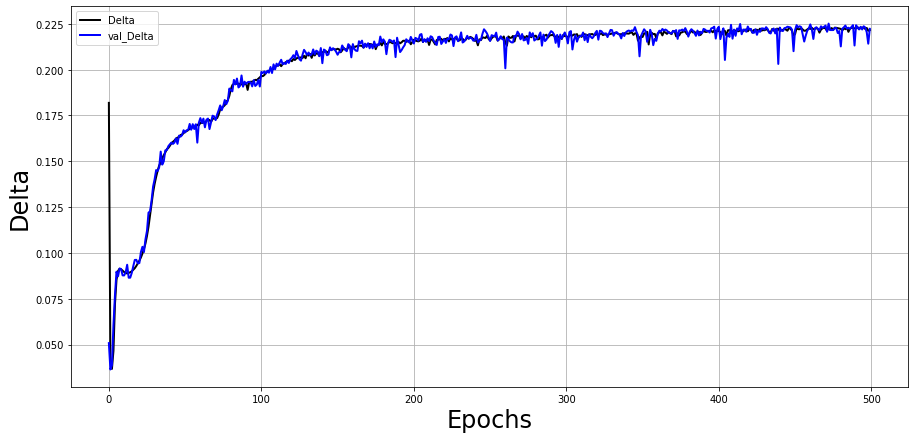

In [23]:
history = np.load('WM_CF/CF.npy',allow_pickle='TRUE').item()

fig, ax = plt.subplots(1,figsize=(15,7), sharey=True)
ax.grid()
ax.plot(history['Delta_DNN'][:],color='black',lw=2,label='Delta')
ax.plot(history['val_Delta_DNN'][:],color='blue',lw=2,label='val_Delta')
plt.legend(loc='best')
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Delta",fontsize=24)

# Part 3 channel noise

## functions

In [11]:
def noise_to_channels_V1(X, channel_ID, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    '''
    Parameters : 
       
        test_set :  test set containing the H channels
    
        col : list of index for the specific column to add noise
    
    Returns:
    
        channel gain ndarray container of noisy channels 

    '''   
   
    var_X = np.var(X[:, channel_ID], axis=0, keepdims=True)
    
    noisy_gains = [] # list to store all the noisy H matrices with different level of noise variance
    
    for SNR_db in SNRs_db:
        
        SNR = np.power(10,SNR_db/10)
        noises = np.sqrt(var_X/SNR)*np.random.normal(0.0, 1.0, (X.shape[0], len(channel_ID)))#len(secondary_ID)
    
        X_noised = X.copy()
        X_noised[:, channel_ID] = X_noised[:, channel_ID] + noises
        noisy_gains.append(X_noised)

    return SNRs_db, np.asarray(noisy_gains, dtype="float64")

In [7]:
def noise_to_channels(X, primary_ID, secondary_ID, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    '''
    Parameters : 
       
        test_set :  test set containing the H channels
    
        col : list of index for the specific column to add noise
    
    Returns:
    
        channel gain ndarray container of noisy channels 

    '''   
   
    #static_var_X = np.sqrt(np.var(X[:, primary_ID], axis=0))

    #var_X = np.var(X[:, secondary_ID], axis=0, keepdims=True)
    var_X = np.var(X[:, secondary_ID+primary_ID], axis=0, keepdims=True)
    
    noisy_gains = [] # list to store all the noisy H matrices with different level of noise variance
    
    for SNR_db in SNRs_db:
        
        SNR = np.power(10,SNR_db/10)
        noises = np.sqrt(var_X/SNR)*np.random.normal(0.0, 1.0, (X.shape[0], len(secondary_ID+primary_ID)))#len(secondary_ID)
    
        X_noised = X.copy()
        #X_noised[:, secondary_ID] = X_noised[:, secondary_ID] + noises
        X_noised[:, secondary_ID+primary_ID] = X_noised[:, secondary_ID+primary_ID] + noises
        #X_noised[:, primary_ID] = static_var_X
        noisy_gains.append(X_noised)

    return SNRs_db, np.asarray(noisy_gains, dtype="float64")


#-----------------------------------------------------------------------------------------#

def AS_A_squeeze(x):
    return CF_V4(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])

def generate_benchmark(H_matrix): 
    '''
    bruteforce for H without noise
    '''
    with Pool() as p:
        BF_res =  p.map(AS_A_squeeze, H_matrix)

    return np.squeeze(np.asarray(BF_res, dtype="float64"))

#-----------------------------------------------------------------------------------------#

def AS_for_noisy_channels(BH_matrix):
    
    '''
    Compute bruteforce method for channel gain ndarray composed of noisy channels
    '''

    BF_res = [] # list containing channels and bruteforce results (Alpha,Pr,Ps) for each noisy matrix (0, 10^-1.5, 10^-1....) 
    
    
    for i in range(BH_matrix.shape[0]) :
        X = BH_matrix[i,:,:]
        
        temp_BF_res = generate_benchmark(X)
        
        BF_res.append(temp_BF_res)

        
    return np.asarray(BF_res, dtype="float64")


#-----------------------------------------------------------------------------------------#





## Analytic solution to noisy test set and test set  without noise ...

In [8]:
P1 = 10.0
tau = 0.25
Primary_ID = [0, 1, 6] 
Secondary_ID = [3, 7]



In [ ]:
# Get Noisy H-MATRIX with different noise variance

noise_levels, NH_MATRIX = noise_to_channels(x_test, Primary_ID, Secondary_ID)



# Compute bruteforce for NH-MATRIX

AS_NG_MATRIX = AS_for_noisy_channels(NH_MATRIX) 

# bruteforce for test_set without noise

AS_G_Benchmark = generate_benchmark(x_test) 

#----------------------------------Save data----------------------------------------------#

outfile_NH_MATRIX = 'Imperfect CSI Data/CF_DNN/NH_MATRIX_GF_CDIT'
np.savez(outfile_NH_MATRIX, NH_MATRIX)


outfile_BF_NG_MATRIX = 'Imperfect CSI Data/CF_DNN/BF_NG_MATRIX_GF_CDIT'
np.savez(outfile_BF_NG_MATRIX, AS_NG_MATRIX)


outfile_BF_G_Benchmark = 'Imperfect CSI Data/CF_DNN/BF_G_Benchmark_GF_CDIT'
np.savez(outfile_BF_G_Benchmark, AS_G_Benchmark)


## loading the data 

In [9]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX = 'Imperfect CSI Data/CF_DNN/NH_MATRIX_GF_CDIT'

NH_MATRIX = np.load(outfile_NH_MATRIX+".npz")
NH_MATRIX.files
NH_MATRIX = NH_MATRIX['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX = 'Imperfect CSI Data/CF_DNN/BF_NG_MATRIX_GF_CDIT'

dataset_test = np.load(outfile_BF_NG_MATRIX+".npz")
dataset_test.files
dataset_test = dataset_test['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark = 'Imperfect CSI Data/CF_DNN/BF_G_Benchmark_GF_CDIT'

dataset = np.load(outfile_BF_G_Benchmark+".npz")
dataset.files
dataset = dataset['arr_0']






## test Analytic solution with noisy channels

In [17]:
#-----------------------------------------------------------------------------------------#


def opportunistic_rate_for_noisy_channels(datas, labels):
    '''
    Parameters: 
        dataset : test_set
        labels : For DNN estimations
    '''
    H_matrix = []
    opportunistic_rate = []
    # create H_matrix ( without noise ) for each noise level labels
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
        
    # calculate rate for the same H with different labels based on noise level
    for i,j in zip(H_matrix,labels) : 
        data , label = i[:,0:8], j[:,8:12]
        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1]))

        opportunistic_rate.append(temp_rate)
        
    return np.asarray(opportunistic_rate, dtype="float64")



def plot_CSI_Imperfect_Stats(res_stats, plot_lab, x_lab, y_lab, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, res_stats, c = 'black',label= plot_lab)

    ax.grid()

    ax.scatter(SNRs_db[0],res_stats[0],label=r'$SNR=-10$',s=200,marker='v',linewidths=1)

    ax.scatter(SNRs_db[1],res_stats[1],label=r'$SNR=-5}$',s=200,marker='o',linewidths=1)

    ax.scatter(SNRs_db[2],res_stats[2],label=r'$SNR=0$',s=200,marker='D',linewidths=1)

    ax.scatter(SNRs_db[3],res_stats[3],label='$SNR=5$',s=200,marker='H',linewidths=1)

    ax.scatter(SNRs_db[4],res_stats[4],label='$SNR=10$',s=200,marker='d',linewidths=1)

    ax.scatter(SNRs_db[5],res_stats[5],label='$SNR=15$',s=200,marker='P',linewidths=1)

    ax.scatter(SNRs_db[6],res_stats[6],label='$SNR=20$',s=200,marker='<',linewidths=1)


    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(loc='best', fontsize=16)

    plt.xlabel(x_lab, fontsize=24) #'Noise variance','Percentage'
    plt.ylabel(y_lab, fontsize=24)
    #plt.xscale('log')
    

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/RAG_opportunistic_rate.pdf', bbox_inches='tight')


def plot_ARPD(mean_ARPD, maximum_ARPD, mean_outage_ARPD, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, maximum_ARPD, c = 'blue',label=r"$Max$",lw=2.5)
    ax.plot(SNRs_db, mean_ARPD, c = 'red',label=r"$Mean$",lw=2.5)
    ax.plot(SNRs_db, mean_outage_ARPD, c = 'gray',label=r"$Mean\; outage$",lw=2.5)

    ax.grid()

    xs = np.linspace(1, 10**1.5, 20)

    plt.hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')

    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)



    ax.legend(loc='upper center', fontsize=16)

    plt.xlabel('SNR (dB)', fontsize=24)
    plt.ylabel('Primary network degradation (%)', fontsize=24)
    #plt.xscale('log')

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/PDD.pdf', bbox_inches='tight')

    
def primary_rate_CF(hR1, h11, h2R, h1R, h22, hR2, h21, h12, PR, PS):

    R_P = C((h11**2*P1)/(hR1**2*PR+h21**2*PS+1))

    return R_P




def mean_max_outage_PARD(N_P_Rate, Max_P_Rate, tau = 0.25):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    
    #res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    #res =  # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res[res>tau])
        except RuntimeWarning:
            mean_outage = 0
            
    outage = np.nanmean(res>tau)
    
    return mean_res, max_res, mean_outage, outage




def relative_avreage_gap(X, Y):
    
    """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

    return (np.mean(X) - np.mean(Y))/(np.mean(Y))       



In [18]:
db_bruteforce = opportunistic_rate_for_noisy_channels(dataset, dataset_test) 
# rate for H without noise
db_benchmark = C(f_obj(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], dataset[:,8], dataset[:,9]))


# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap = np.array([relative_avreage_gap(db_bruteforce[0,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[1,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[2,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[3,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[4,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[5,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[6,:], db_benchmark[:])])

db_gap = db_gap*100



SNRs_db = [-10, -5, 0, 5, 10, 15, 20]



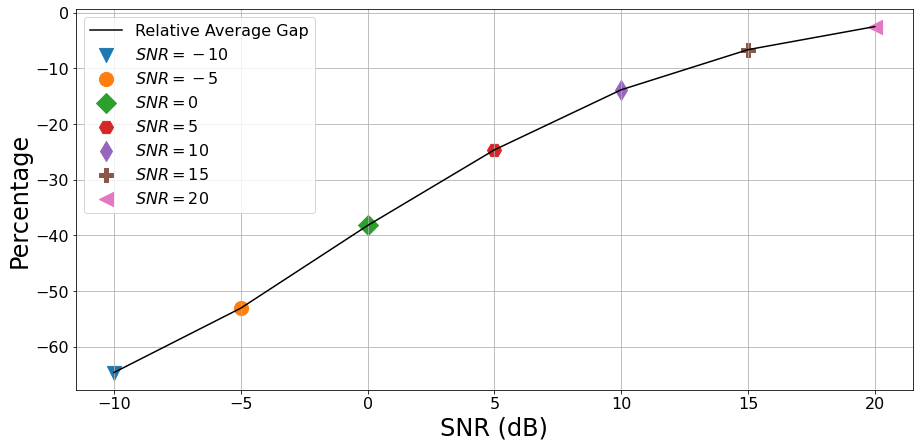

In [19]:
plot_CSI_Imperfect_Stats(db_gap, 'Relative Average Gap', 'SNR (dB)','Percentage')

In [20]:

def PARD_for_noisy_data(datas, labels, Pp=10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:11]
        
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1])
        
        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP
        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100



Mean_ARPD, Max_ARPD, Mean_Outage_ARPD, Outage_ARPD = PARD_for_noisy_data(dataset,dataset_test)



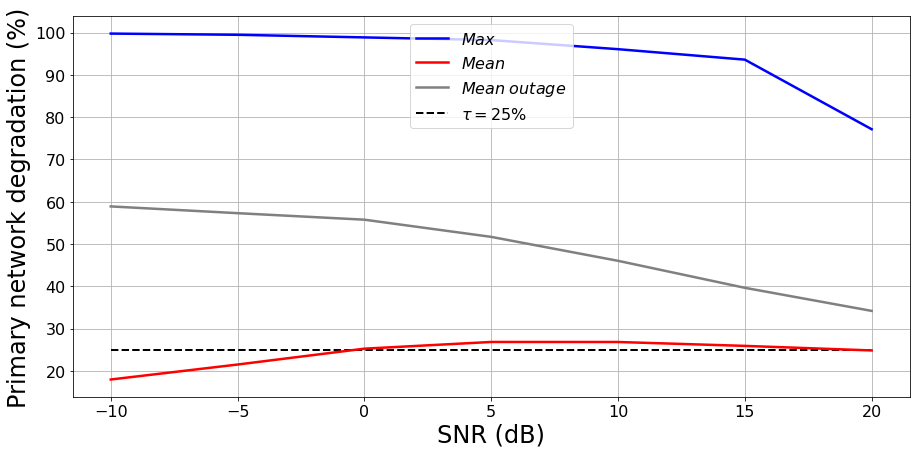

In [21]:
plot_ARPD(Mean_ARPD, Max_ARPD, Mean_Outage_ARPD)

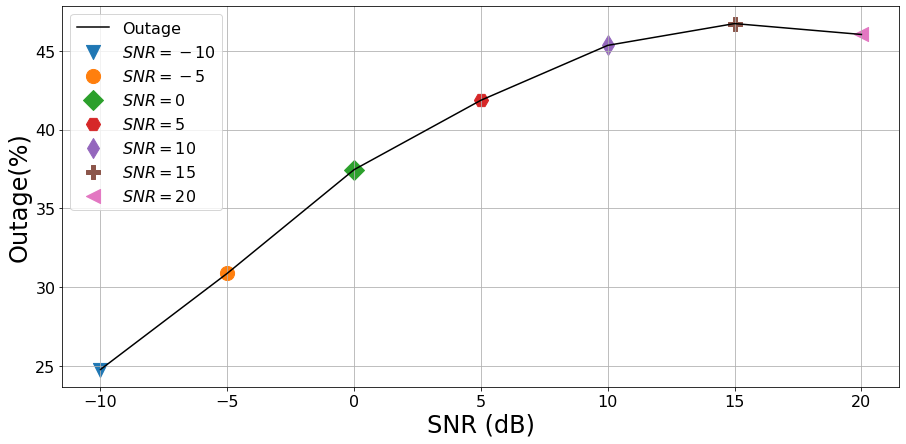

In [22]:

plot_CSI_Imperfect_Stats(Outage_ARPD, 'Outage', 'SNR (dB)','Outage(%)')



## Deep Neural Network (trained without noise)

## test DNN with noisy channels

In [23]:
def DNN_predictions(NH_MATRIX, mw_path, Lambda=10**0.5, tau = 0.25):
    '''
    NH_MATRIX : Noisy H matrix 
    '''
    final_predictions = []
   

    model = tf.keras.models.load_model(mw_path, custom_objects={'CF_loss':loss_CF(Lambda,tau),\
                                                                'Delta_DNN':\
                                                                Delta_DNN,\
                                                                'outage_percentage':\
                                                                outage_percentage,\
                                                                                           
                                                                'custom_sigmoid':custom_sigmoid,
                                                                "opportunistic_rate":\
                                                                Opportunistic_Achievable_Rate(tau) })
    
    
    for i in NH_MATRIX : 
        data = i[:,0:8]
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
        
    return np.asarray(final_predictions, dtype="float64")

def opportunistic_rate_for_noisy_channels_DNN(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2))
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")

def primary_degradation_for_noisy_data_DNN(datas, labels):
    final_pdd = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data, y_hat = i[:,0:8], j
        temp_pdd = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2)
        final_pdd.append(temp_pdd)
        
    return np.asarray(final_pdd, dtype="float64")


 

2022-03-14 11:20:58.891386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-14 11:20:58.909688: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2022-03-14 11:20:58.987178: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-14 11:20:59.611339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


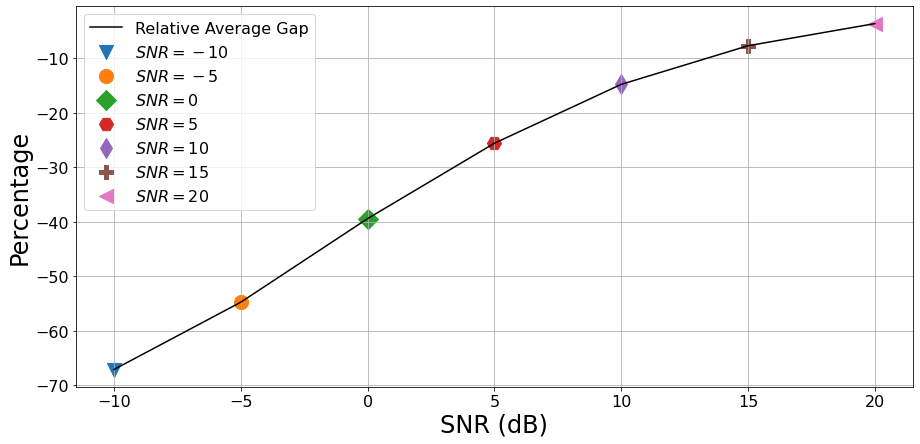

In [24]:
#"weights_model/gaussian_fading_model/anne_model.h5"
Model_Weight_Path = "WM_CF/CF.h5"

DNN_pred = DNN_predictions(NH_MATRIX, Model_Weight_Path)
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)
db_benchmark = C(f_obj(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], dataset[:,8], dataset[:,9]))


db_gap_DNN = np.array([relative_avreage_gap(db_DNN[0,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[1,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[2,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[3,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[4,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[5,:], db_benchmark[:]),\
                       relative_avreage_gap(db_DNN[6,:], db_benchmark[:])])
#,\
#                       relative_avreage_gap(db_DNN[7,:,8], db_benchmark[:,8])


#ax.plot(variance, db_gap, c = 'blue',label='BF')

db_gap_DNN = db_gap_DNN*100

plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')

In [25]:

def PARD_for_noisy_data_DNN(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0]**2, label[:,1]**2)

        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100





Mean_ARPD, Max_ARPD, Mean_Outage_ARPD, Outage_ARPD = PARD_for_noisy_data_DNN(dataset, DNN_pred)


In [26]:
Mean_Outage_ARPD

array([58.98064343, 57.38246734, 55.44023107, 51.64174724, 46.09640224,
       40.00420923, 34.37594787])

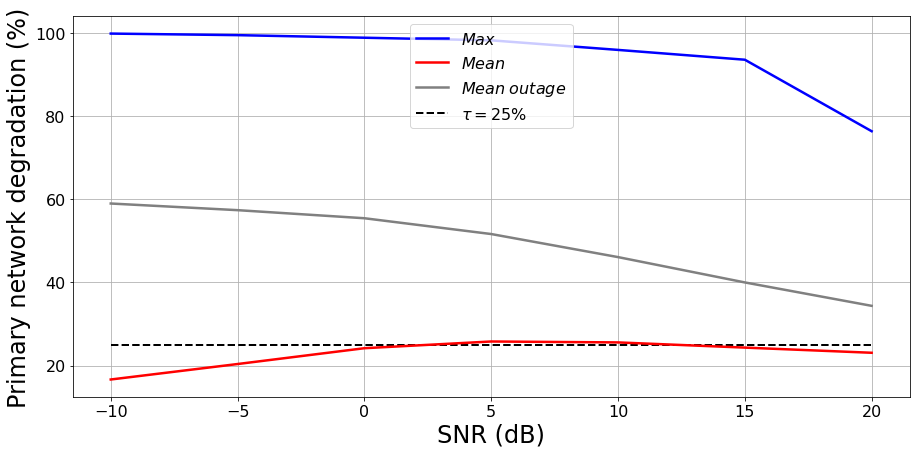

In [27]:
plot_ARPD(Mean_ARPD, Max_ARPD, Mean_Outage_ARPD)

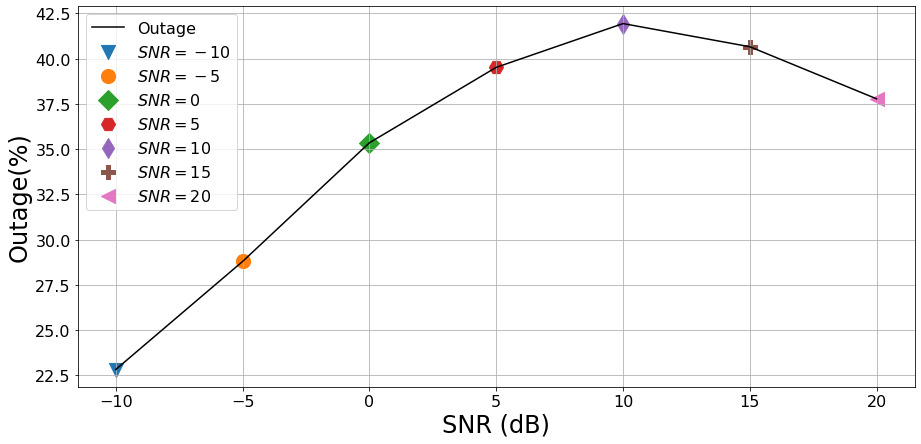

In [28]:

plot_CSI_Imperfect_Stats(Outage_ARPD, 'Outage', 'SNR (dB)','Outage(%)')



## Training DNN with noisy channels

## Noise to train set

In [101]:

# Get P and S channels index form dataset (h_R1, h_11, h_2R, h_1R, h_22, h_R2, h_21, h_12)

Primary_ID = [0, 1, 6] 
Secondary_ID = [3, 7]


noise_levels, X_train_noised = noise_to_channels(x_train, Primary_ID, Secondary_ID)
X_train_noised_path = 'Imperfect CSI Data/CF_DNN/X_train_noised_GF_CDIT'
np.savez(X_train_noised_path, X_train_noised)






In [102]:
#X_train_noised_GF = 'Dataset_VF/X_train_noised_anne'
X_train_noised_path = 'Imperfect CSI Data/CF_DNN/X_train_noised_GF_CDIT'

X_train_noised = np.load(X_train_noised_path+".npz")
X_train_noised.files
X_train_noised = X_train_noised['arr_0']



In [21]:
def DNN_for_noisy_channels(X, X_noised_train, hyperparameters, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    #X_noised_train, X_noised_val,hyperparameters, noise_levels = [0, 10**-1.5, 10**-1, 10**-0.5, 1, 10**0.5, 10**1, 10**1.5]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_DNN_results = []
    
    ind = 0
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
    
    for x_noisy in X_noised_train : 

        model = get_model_CF(x_noisy, loss_CF(hyperparameters["lambda"],\
                                                 hyperparameters["tau"]),\
                                                 hyperparameters["metrics"],\
                                                 custom_sigmoid,\
                                                 custom_sigmoid,\
                                                 hyperparameters["learning_rate"])

        history = model.fit(x_noisy, np.power(X, 2), epochs=hyperparameters["epochs"], batch_size=hyperparameters["batch_size"], validation_split=hyperparameters["validation_split"], callbacks=[callback])#validationhyperparameters["batch_size"]_split = VS
        
        model.save('Weights_Model/CSI imperfection/CDIT/v2_'+str(SNRs_db[ind])+'.h5')
        np.save('Weights_Model/CSI imperfection/CDIT/v2_'+str(SNRs_db[ind]),history.history)
        
        ind+=1
#-----------------------------------------------------------------------------------------#        
Nbr_train = int(1E6)

 
tau = 0.25

VS = 0.2 # validation_split

Epochs = 500 # Epochs number

BS = 4096 # batch_size

LD = 10**0.5

LR = 10**-4


metrics = [Delta_DNN, Opportunistic_Achievable_Rate(tau),outage_percentage(tau)] #, QoS_mean_DF, QoS_median_DF



#Nbr_train = int(1E6)

hyperparameters = {'lambda' : LD, 'tau': tau, 'metrics': metrics, 'learning_rate': LR, 'epochs':Epochs, 'batch_size': BS, 'validation_split': VS}
#hyperparameters = [LD, tau, metrics, LR, Epochs, BS, VS]
DNN_for_noisy_channels(x_train[:Nbr_train,:], X_train_noised[:,:Nbr_train,:], hyperparameters)






NameError: name 'X_train_noised' is not defined

In [29]:
def noised_DNN_pred_V2(X, mw_path, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_predictions = []
    tau = 0.25
    for snr_item in SNRs_db : 
        for noisy_X in X:
            data = noisy_X[:,0:8]
            model = tf.keras.models.load_model(mw_path+str(snr_item)+'.h5', custom_objects={'CF_loss':loss_CF(Lambda,tau),\
                                                                'Delta_DNN':Delta_DNN,       
                                                                 'custom_sigmoid':custom_sigmoid,
                                                                 "opportunistic_rate":Opportunistic_Achievable_Rate(tau),  
                                                                 'outage_percentage':outage_percentage    })
            temp_predictions = model.predict(data)
            final_predictions.append(temp_predictions)
    
    return np.asarray(final_predictions, dtype="float64")



DNN_pred = noised_DNN_pred_V2(NH_MATRIX, 'Weights_Model/CSI imperfection/CDIT/v2_')



In [30]:
def plot_history_noised_DNN(path_to_history, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    loss, val_loss = [], []
    for item in SNRs_db:
        history = np.load(path_to_history+str(item)+'.npy',allow_pickle='TRUE').item()
        loss.append(history['loss'][:])
        val_loss.append(history['val_loss'][:])
    return loss, val_loss
loss_history, val_loss_history = plot_history_noised_DNN('Weights_Model/CSI imperfection/CDIT/v2_')    



Text(0, 0.5, 'Loss')

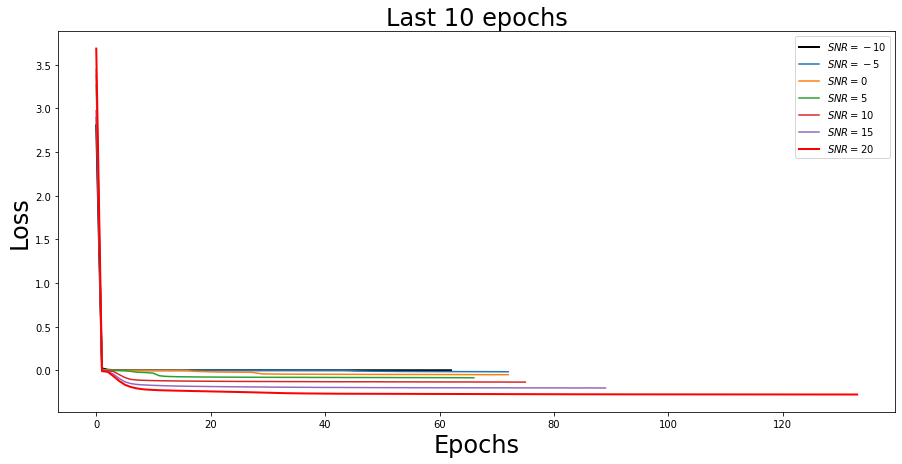

In [31]:
fig, ax = plt.subplots(1,figsize=(15,7), sharey=True)

plt.title("Last 10 epochs", fontsize=24)
ax.plot(np.arange(0,len(loss_history[0]),1), loss_history[0],label="$SNR=-10$",color='black',lw=2)
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[1],label=r"$SNR=-5$")
ax.plot(np.arange(0,len(loss_history[2]),1), loss_history[2],label=r"$SNR=0$")
ax.plot(np.arange(0,len(loss_history[3]),1), loss_history[3],label=r"$SNR=5$")
ax.plot(np.arange(0,len(loss_history[4]),1), loss_history[4],label=r"$SNR=10$")
ax.plot(np.arange(0,len(loss_history[5]),1), loss_history[5],label=r"$SNR=15$")
ax.plot(np.arange(0,len(loss_history[6]),1), loss_history[6],label=r"$SNR=20$",color='red',lw=2)
#ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[7],label=r"$10^{1.5}$")

ax.legend(loc="best")
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Loss",fontsize=24)

Text(0, 0.5, 'Validation Loss')

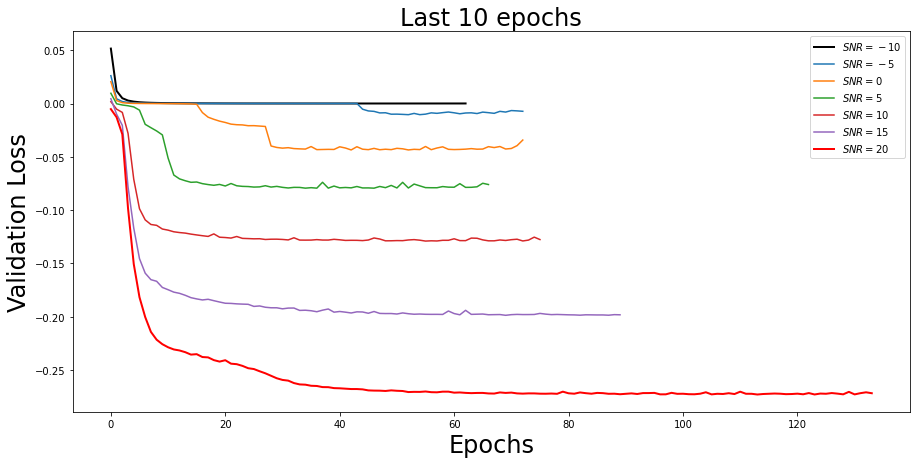

In [32]:
fig, ax = plt.subplots(1,figsize=(15,7))
plt.title("Last 10 epochs", fontsize=24)
ax.plot(np.arange(0,len(val_loss_history[0]),1), val_loss_history[0],label="$SNR=-10$",color='black',lw=2)
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[1],label=r"$SNR=-5$")
ax.plot(np.arange(0,len(val_loss_history[2]),1), val_loss_history[2],label=r"$SNR=0$")
ax.plot(np.arange(0,len(val_loss_history[3]),1), val_loss_history[3],label=r"$SNR=5$")
ax.plot(np.arange(0,len(val_loss_history[4]),1), val_loss_history[4],label=r"$SNR=10$")
ax.plot(np.arange(0,len(val_loss_history[5]),1), val_loss_history[5],label=r"$SNR=15$")
ax.plot(np.arange(0,len(val_loss_history[6]),1), val_loss_history[6],label=r"$SNR=20$",color='red',lw=2)
#ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[7],label=r"$10^{1.5}$")
ax.legend(loc="best")
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Validation Loss",fontsize=24)

In [33]:
def db_gap_Dnn(acheivable_rate, acheivable_rate_bruteforce, mul):
    
    db_gap_DNN = np.array([relative_avreage_gap(acheivable_rate[mul,:],\
                                                acheivable_rate_bruteforce[:])])
    return db_gap_DNN*100

def opportunistic_rate_for_noisy_channels_DNN(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j

        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2))


        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")


def PARD_for_noisy_data_DNN(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0]**2, label[:,1]**2)


        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100








In [34]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)
db_benchmark = C(f_obj(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], dataset[:,8], dataset[:,9]))


Mean_ARPD_DNN, Max_ARPD_DNN, Mean_Outage_ARPD_DNN, Outage_ARPD_DNN = PARD_for_noisy_data_DNN(dataset, DNN_pred)



In [35]:
def get_dnn_results(X, bruteforce_rate, SNR_ID= [0, 8, 16, 24, 32, 40, 48]): 
    
    rate_gap, max_pard, mean_pard, mean_outage_pard, outage_pard  = [], [], [], [], []
    for ID in SNR_ID : 
        rate_gap.append(db_gap_Dnn(X["opportunistic_rate"], bruteforce_rate, [ID])) #X[0]
        mean_pard.append(X["mean_ARPD"][ID])
        max_pard.append(X["max_ARPD"][ID])
        mean_outage_pard.append(X["mean_outage"][ID])
        outage_pard.append(X["outage_ARPD"][ID])
    return rate_gap, mean_pard, max_pard, mean_outage_pard, outage_pard

X = {"opportunistic_rate":db_DNN, "mean_ARPD":Mean_ARPD_DNN,"max_ARPD":Max_ARPD_DNN,\
    "mean_outage":Mean_Outage_ARPD_DNN, "outage_ARPD":Outage_ARPD_DNN}

rate_gap_dnn, mean_pard_dnn, max_pard_dnn, mean_outage_pard_dnn, outage_pard_dnn = get_dnn_results(X, db_benchmark)

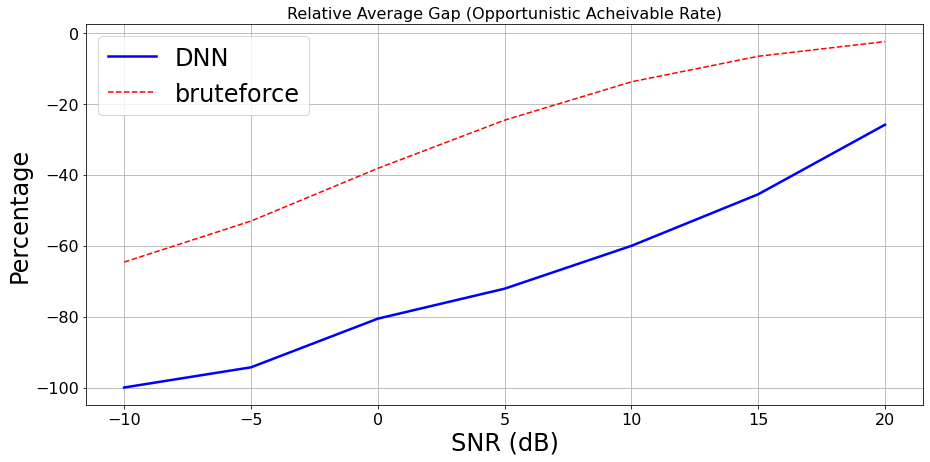

In [26]:
SNRs_db = [-10,-5,0,5,10,15,20]
fig, ax = plt.subplots(1, 1,figsize=(15,7), sharey=True)

ax.plot(SNRs_db, rate_gap_dnn, c = 'blue',lw=2.5,label="DNN")
plt.plot([-10,-5,0,5,10,15,20], db_gap,color="red",linestyle='dashed',label="bruteforce")# bruteforc
ax.grid()
plt.xlabel("SNR (dB)",fontsize=24)
plt.ylabel("Percentage",fontsize=24)
plt.title("Relative Average Gap (Opportunistic Acheivable Rate)", fontsize=16)
plt.tick_params(axis='x', labelsize=16 )
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc='best',fontsize=24)

In [27]:
def plot_ARPD_Subplots(mean_ARPD, maximum_ARPD, mean_outage_ARPD, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1, 2,figsize=(15,7), sharey=True)

    ax[0].plot(SNRs_db, maximum_ARPD[0], c = 'blue',label=r"$Max$",lw=2.5)
    ax[0].plot(SNRs_db, mean_ARPD[0], c = 'red',label=r"$Mean$",lw=2.5)
    ax[0].plot(SNRs_db, mean_outage_ARPD[0], c = 'gray',label=r"$Mean\; outage$",lw=2.5)
    
    ax[1].plot(SNRs_db, maximum_ARPD[1], c = 'blue',label=r"$Max$",lw=2.5)
    ax[1].plot(SNRs_db, mean_ARPD[1], c = 'red',label=r"$Mean$",lw=2.5)
    ax[1].plot(SNRs_db, mean_outage_ARPD[1], c = 'gray',label=r"$Mean\; outage$",lw=2.5)


    ax[0].grid()
    ax[1].grid()


    xs = np.linspace(1, 10**1.5, 20)

    ax[0].hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')
    ax[1].hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')

    

    ax[0].tick_params(axis='x', labelsize=16 )
    ax[0].tick_params(axis='y', labelsize=16)
    ax[1].tick_params(axis='x', labelsize=16 )
    ax[1].tick_params(axis='y', labelsize=16)




    ax[0].legend(loc='upper center', fontsize=16)
    ax[1].legend(loc='upper center', fontsize=16)

    
    ax[0].set_ylabel('Primary network degradation (%)', fontsize=24)
    ax[0].set_xlabel('SNR (dB)', fontsize=24)
    ax[1].set_xlabel('SNR (dB)', fontsize=24)
    #plt.xlabel('SNR (dB)', fontsize=24)
    #plt.ylabel('Primary network degradation (%)', fontsize=24)
    #plt.xscale('log')




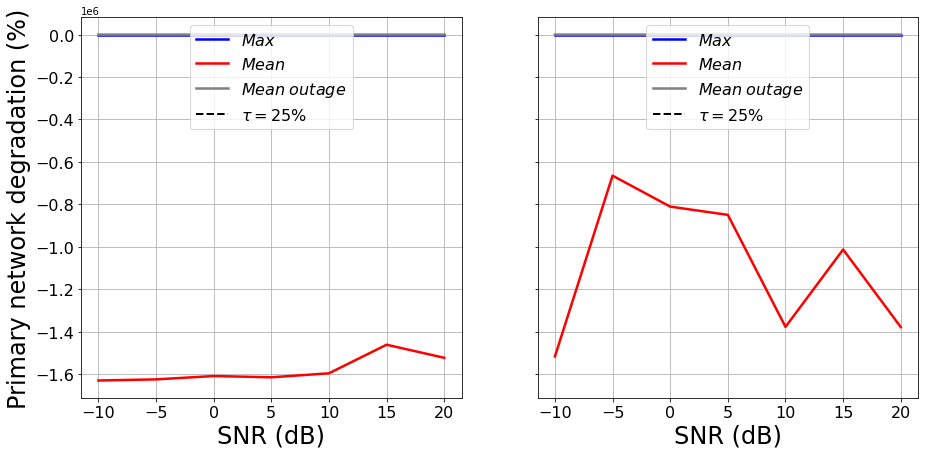

In [28]:
X, Y, Z = [mean_pard_dnn, Mean_ARPD], [max_pard_dnn, Max_ARPD], [mean_outage_pard_dnn, Mean_Outage_ARPD]

plot_ARPD_Subplots(X,Y,Z)

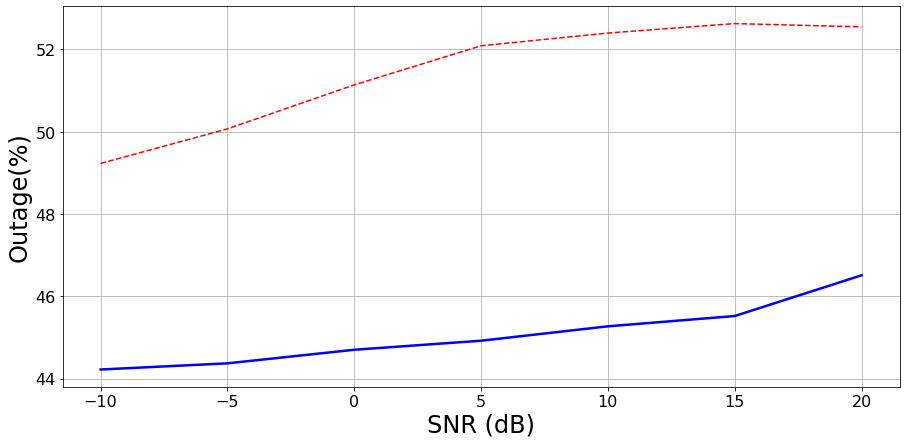

In [30]:
fig, ax = plt.subplots(1, 1,figsize=(15,7), sharey=True)

ax.plot(SNRs_db, outage_pard_dnn, c = 'blue',label=r"$$",lw=2.5)
plt.plot([-10,-5,0,5,10,15,20], Outage_ARPD,color="red",linestyle='dashed')# bruteforc
ax.grid()
plt.xlabel("SNR (dB)",fontsize=24)
plt.ylabel("Outage(%)",fontsize=24)
plt.tick_params(axis='x', labelsize=16 )
plt.tick_params(axis='y', labelsize=16)